# **Installation**

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import norm
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import RidgeCV
from lightgbm import LGBMRegressor
from scipy.sparse import csr_matrix
import optuna

import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_predict,cross_val_score 

In [3]:
import lazypredict
import pandas as pd
from lazypredict.Supervised import LazyRegressor
from sklearn.model_selection import train_test_split

# **Data Import**

In [4]:
# Create a DataFrame from CSV data
df = pd.read_csv("strokes.csv")

# **Feature Engineering**

In [5]:
selected_columns = ['player_id', 'last_name', 'round','hole','hole_score','par_value','yardage', 'shot', 'shot_type', 'num_of_strokes',
       'from_location_scorer', 'from_location_laser', 'to_location_scorer',
       'to_location_laser', 'distance', 'distance_to_pin', 'in_the_hole',
       'around_the_green', 'first_putt', 'dist_to_hole_after_shot', 'time',
       'lie', 'elevation', 'slope', 'x', 'y', 'z', 'dist_from_center',
       'dist_from_edge']  # Add the column names you want to select
df = df[selected_columns].copy()

#inches to yards
df['distance_to_pin'] = df['distance_to_pin']/36

df['dist_to_hole_after_shot'] = df['dist_to_hole_after_shot']/36


In [6]:
df['lie_location'] =    np.where(df['dist_to_hole_after_shot'] == 0, 'Hole',
                        np.where(df['to_location_laser'].str.contains('Rough', case=False), 'Rough',
                        np.where(df['to_location_scorer'].str.contains('Rough', case=False), 'Rough',
                        np.where(df['to_location_scorer'].str.contains('Bunker', case=False), 'Bunker',
                        np.where(df['to_location_scorer'].str.contains('Green', case=False), 'Green',
                        np.where(df['to_location_laser'].str.contains('Fairway', case=False), 'Fairway',
                        np.where(df['to_location_scorer'].str.contains('Tree', case=False), 'Rough',
                        #np.where(df['dist_to_hole_after_shot'] == 0, 'Hole',
                        #distance_to_hole_after_the_shot == 0 ~ 'Hole',
                        np.where(df['to_location_scorer'].str.contains('Water', case=False), 'Water', 'Unknown'))))))))

# df = df[df['lie_location'] != 'Unknown']
df['round_hole_combination'] = (df['round'] - 1) * 18 + df['hole']

df['strokes_to_hole_out'] = df['hole_score'] - df['shot'] +1 
#instead of 1, should be df['num_of_strokes']
#then shots after water mark as provisionals
#drop shots from water
#plot a out a water penalty hole just to check

# **Drop Holes with Penalties**

- Figure out how to use the 400 discarded rows in the future

In [7]:
df['flag_strokes_to_hole_out_1_or_less'] = df['strokes_to_hole_out'] <= 0

selected_rows = df[df['flag_strokes_to_hole_out_1_or_less']]

# Get the 'player_id' and 'round_hole_combination' for the selected rows
players_to_remove = selected_rows[['player_id', 'round_hole_combination']]

# Remove corresponding 'round_hole_combination' for each player
result_df = df.merge(players_to_remove, on=['player_id', 'round_hole_combination'], how='left', indicator=True)
result_df = result_df[result_df['_merge'] == 'left_only']

# Drop the indicator column and reset the index
result_df = result_df.drop(columns=['_merge']).reset_index(drop=True)

# **Drop Holes with Water or Unknown Lies**

In [8]:
result_df['flag_water_or_unknown_lies'] = (result_df['lie_location'] == 'Water') | (result_df['lie_location'] == 'Unknown')

selected_rows = result_df[result_df['flag_water_or_unknown_lies']]

# Get the 'player_id' and 'round_hole_combination' for the selected rows
players_to_remove = selected_rows[['player_id', 'round_hole_combination']]

# Remove corresponding 'round_hole_combination' for each player
result_df = result_df.merge(players_to_remove, on=['player_id', 'round_hole_combination'], how='left', indicator=True)
result_df = result_df[result_df['_merge'] == 'left_only']

# Drop the indicator column and reset the index
result_df = result_df.drop(columns=['_merge']).reset_index(drop=True)

# **Drop Holes with Non Standards Shot Types**

In [9]:
result_df['flag_non_standard_shot_types'] = result_df['shot_type'] != 'S'

selected_rows = result_df[result_df['flag_non_standard_shot_types']]

#-----

# Get the 'player_id' and 'round_hole_combination' for the selected rows
players_to_remove = selected_rows[['player_id', 'round_hole_combination']]

# Remove corresponding 'round_hole_combination' for each player
result_df = result_df.merge(players_to_remove, on=['player_id', 'round_hole_combination'], how='left', indicator=True)
result_df = result_df[result_df['_merge'] == 'left_only']

# Drop the indicator column and reset the index
result_df = result_df.drop(columns=['_merge']).reset_index(drop=True)

In [10]:
# Shift all values in the 'column_name' down by one row
result_df['lie_location'] = result_df['lie_location'].shift(1)

result_df['lie_location'] =    np.where(result_df['shot'] == 1, 'Tee',result_df['lie_location'])

#sanity check tee looks good
#result_df[['last_name', 'round_hole_combination','shot', 'hole_score','strokes_to_hole_out','distance_to_pin','lie_location','first_putt']].iloc[:10]

# sanity check making sure no chip ins

# idx = result_df.groupby('round_hole_combination')['shot'].idxmax()

# result_df[['distance_to_pin','lie_location','first_putt','to_location_laser','to_location_scorer']].loc[idx].iloc[:30]


# **Distance to Pin vs Strokes to Hole Out**

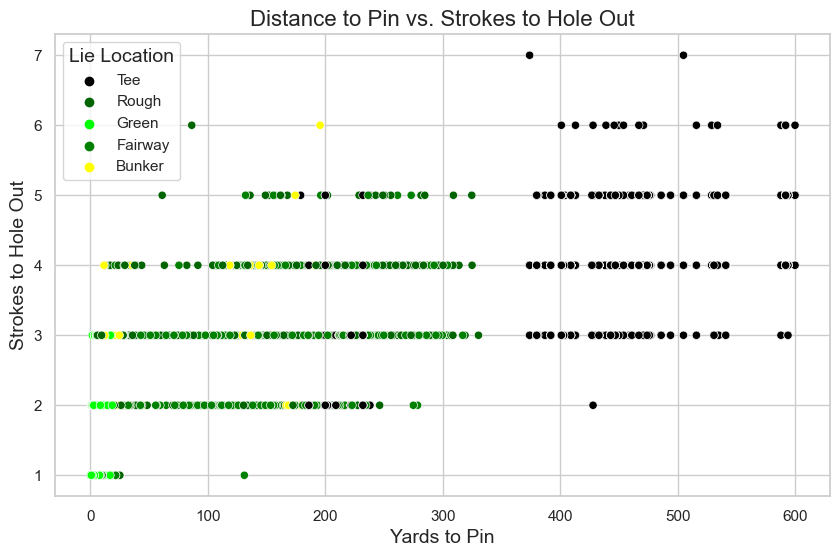

In [11]:
# Define a color palette
pal = {
    'Rough': '#006400',
    'Green': '#00FF00',
    'Fairway': '#008000',
    'Bunker': 'yellow',
    'Tee': 'black'
}

# Set Seaborn style
sns.set(style='whitegrid')

# Create scatter plot with improved aesthetics
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(x='distance_to_pin', y='strokes_to_hole_out', hue='lie_location', palette=pal, data=result_df)

# Set plot title and labels
plt.title('Distance to Pin vs. Strokes to Hole Out', fontsize=16)
plt.xlabel('Yards to Pin', fontsize=14)
plt.ylabel('Strokes to Hole Out', fontsize=14)

# Customize legend
scatter_plot.legend(title='Lie Location', title_fontsize='14', loc='upper left')

# Show the plot
plt.show()

# **Lazy Predict**

In [12]:
numeric_features = ['distance_to_pin',"dist_from_center"]
numeric_transformer = Pipeline(steps=[
    ("scaler", RobustScaler())
])

categorical_features = ["lie_location",'round','hole','par_value','slope','elevation','lie']
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(transformers=[
    ("num_transform", numeric_transformer, numeric_features),
    ("cat_transform", categorical_transformer, categorical_features)
])

In [13]:
feature_cols = ["lie_location",'round','hole','par_value','slope','elevation','lie','distance_to_pin',"dist_from_center"]
X = result_df.loc[:, feature_cols]

target_cols = ['strokes_to_hole_out']
y = result_df.loc[:, target_cols]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.95, test_size=0.05,random_state=42,stratify = X[['lie_location',"par_value",'hole']])

In [14]:
reg = LazyRegressor(verbose=0,ignore_warnings=False, custom_metric=None )

models,predictions = reg.fit(X_train, X_valid, y_train.values.ravel(), y_valid.values.ravel())

 76%|███████▌  | 32/42 [00:47<00:07,  1.36it/s]

QuantileRegressor model failed to execute
Solver interior-point is not anymore available in SciPy >= 1.11.0.


100%|██████████| 42/42 [01:02<00:00,  1.04s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000793 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 559
[LightGBM] [Info] Number of data points in the train set: 7663, number of used features: 19
[LightGBM] [Info] Start training from score 2.500196


100%|██████████| 42/42 [01:02<00:00,  1.50s/it]


In [15]:
models

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
GradientBoostingRegressor,0.88,0.88,0.41,2.34
LGBMRegressor,0.88,0.88,0.42,0.29
HistGradientBoostingRegressor,0.88,0.88,0.42,1.10
AdaBoostRegressor,0.87,0.87,0.43,0.65
RandomForestRegressor,0.87,0.87,0.43,6.10
MLPRegressor,0.86,0.87,0.44,6.58
XGBRegressor,0.86,0.86,0.44,0.37
BaggingRegressor,0.86,0.86,0.45,0.88
KNeighborsRegressor,0.84,0.85,0.47,0.12


In [16]:
predictions

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
GradientBoostingRegressor,0.88,0.88,0.41,2.34
LGBMRegressor,0.88,0.88,0.42,0.29
HistGradientBoostingRegressor,0.88,0.88,0.42,1.10
AdaBoostRegressor,0.87,0.87,0.43,0.65
RandomForestRegressor,0.87,0.87,0.43,6.10
MLPRegressor,0.86,0.87,0.44,6.58
XGBRegressor,0.86,0.86,0.44,0.37
BaggingRegressor,0.86,0.86,0.45,0.88
KNeighborsRegressor,0.84,0.85,0.47,0.12


# **Optuna**

In [17]:
feature_cols = ["lie_location",'round','hole','par_value','slope','elevation','lie','distance_to_pin',"dist_from_center"]
X = result_df.loc[:, feature_cols]

categorical_cols = ["lie_location",'round','hole','par_value','slope','elevation','lie']
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

target_cols = ['strokes_to_hole_out'] 
y = result_df.loc[:, target_cols]

# Extract the columns for stratification
stratify_cols = ["lie_location", "par_value", "hole"]
stratify_data = result_df[stratify_cols]

# Split the data, using 'stratify_data' for stratification
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=stratify_data)

# GradientBoostingRegressor

In [18]:
# def objective(trial):
#     params = {
#         "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
#         "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
#         "max_depth": trial.suggest_int("max_depth", 3, 10),
#         "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
#         "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
#         "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
#         "max_features": trial.suggest_uniform("max_features", 0.1, 1.0),
#     }

#     model = GradientBoostingRegressor(**params, random_state=42)

#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_valid)

#     mse = mean_squared_error(y_valid, y_pred)
#     return mse

# # Create and run the Optuna study
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=100, timeout=600)  # You can adjust the number of trials

# # Print the best hyperparameters
# print('Best trial:')
# best_trial = study.best_trial
# print('  Value: {:.4f}'.format(best_trial.value))
# print('  Params: ')
# for key, value in best_trial.params.items():
#     print('    {}: {}'.format(key, value))


# LGBMRegressor

In [19]:
# def objective(trial):
#     params = {
#         "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
#         "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
#         "max_depth": trial.suggest_int("max_depth", 3, 10),
#         "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
#         "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
#         "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
#         "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-8, 10.0),
#         "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-8, 10.0),
#     }

#     model = LGBMRegressor(**params, random_state=42)

#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_valid)

#     mse = mean_squared_error(y_valid, y_pred)
#     return mse

# # Create and run the Optuna study
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=100, timeout=600)  # You can adjust the number of trials

# # Print the best hyperparameters
# print('Best trial:')
# best_trial = study.best_trial
# print('  Value: {:.4f}'.format(best_trial.value))
# print('  Params: ')
# for key, value in best_trial.params.items():
#     print('    {}: {}'.format(key, value))

# AdaBoostRegressor

In [20]:
# def objective(trial):
#     params = {
#         "n_estimators": trial.suggest_int("n_estimators", 50, 500),
#         "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 1.0),
#         # Add any other relevant hyperparameters for AdaBoostRegressor
#     }

#     model = AdaBoostRegressor(**params, random_state=42)

#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_valid)

#     mse = mean_squared_error(y_valid, y_pred)
#     return mse

# # Create and run the Optuna study
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=100, timeout=600)  # You can adjust the number of trials

# # Print the best hyperparameters
# print('Best trial:')
# best_trial = study.best_trial
# print('  Value: {:.4f}'.format(best_trial.value))
# print('  Params: ')
# for key, value in best_trial.params.items():
#     print('    {}: {}'.format(key, value))


# RandomForestRegressor

In [21]:
# def objective(trial):
#     params = {
#         "n_estimators": trial.suggest_int("n_estimators", 50, 500),
#         "max_depth": trial.suggest_int("max_depth", 3, 20),
#         "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
#         "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
#         "max_features": trial.suggest_uniform("max_features", 0.1, 1.0),
#     }

#     model = RandomForestRegressor(**params, random_state=42)

#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_valid)

#     mse = mean_squared_error(y_valid, y_pred)
#     return mse

# # Create and run the Optuna study
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=100, timeout=600)  # You can adjust the number of trials

# # Print the best hyperparameters
# print('Best trial:')
# best_trial = study.best_trial
# print('  Value: {:.4f}'.format(best_trial.value))
# print('  Params: ')
# for key, value in best_trial.params.items():
#     print('    {}: {}'.format(key, value))

# MLPRegressor

In [22]:
# def objective(trial):
#     params = {
#         "hidden_layer_sizes": trial.suggest_int("hidden_layer_sizes", 1, 100),
#         "alpha": trial.suggest_loguniform("alpha", 1e-6, 1.0),
#         "learning_rate_init": trial.suggest_loguniform("learning_rate_init", 1e-5, 1e-1),
#         "max_iter": trial.suggest_int("max_iter", 100, 1000),
#     }

#     model = MLPRegressor(**params, random_state=42)

#     model.fit(X_train, y_train.values.ravel())  # Note: MLPRegressor expects a 1D array for the target variable
#     y_pred = model.predict(X_valid)

#     mse = mean_squared_error(y_valid, y_pred)
#     return mse

# # Create and run the Optuna study
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=100, timeout=600)  # You can adjust the number of trials

# # Print the best hyperparameters
# print('Best trial:')
# best_trial = study.best_trial
# print('  Value: {:.4f}'.format(best_trial.value))
# print('  Params: ')
# for key, value in best_trial.params.items():
#     print('    {}: {}'.format(key, value))


# Optuna for Final Estimator's Meta Model

In [23]:
# # Assuming you have X_train, X_valid, y_train, y_valid defined

# # Define your base models
# base_models = [
#     ("GradientBoostingRegressor_pipeline", GradientBoostingRegressor(
#         n_estimators=298,
#         learning_rate= 0.017565096916826627,
#         max_depth= 4,
#         subsample= 0.9480233926615609,
#         min_samples_split= 9,
#         min_samples_leaf= 3,
#         max_features= 0.8625158448136574
#     )),
#     ("LGBMRegressor_pipeline", LGBMRegressor(
#         n_estimators= 442,
#         learning_rate= 0.009437712702673798,
#         max_depth= 4,
#         subsample= 0.6659162524367865,
#         colsample_bytree= 0.7446478198020141,
#         min_child_samples= 6,
#         reg_alpha= 6.32482216734694e-05,
#         reg_lambda= 0.001956292371616008)),
#     ("AdaBoostRegressor_pipeline", AdaBoostRegressor( 
#         n_estimators= 498,
#         learning_rate= 0.013946367159574381)),
#     ("RandomForestRegressor_pipeline", RandomForestRegressor(
#             n_estimators= 347,
#             max_depth= 7,
#             min_samples_split= 10,
#             min_samples_leaf= 7,
#             max_features= 0.5624136409317273)),
#     ("MLPRegressor_pipeline", MLPRegressor(
#       hidden_layer_sizes= 61,
#       alpha= 0.0016007134120975964,
#       learning_rate_init= 0.0002972290214448905,
#       max_iter= 226))
# ]

# # Create the stack model with fixed base models
# stack_model = StackingRegressor(estimators=base_models, final_estimator=GradientBoostingRegressor())

# def objective(trial):
#     # Define hyperparameters for the final estimator (meta-model)
#     meta_params = {
#         "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
#         "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
#         "max_depth": trial.suggest_int("max_depth", 3, 10),
#         "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
#         "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
#         "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
#         "max_features": trial.suggest_uniform("max_features", 0.1, 1.0)
#     }

#     # Create a new instance of GradientBoostingRegressor with tuned hyperparameters
#     final_estimator = GradientBoostingRegressor(**meta_params)

#     # Set the new final estimator in the stack model
#     stack_model.final_estimator = final_estimator

#     # Fit the stack model on the training data
#     stack_model.fit(X_train, y_train.values.ravel())

#     # Make predictions on the validation data
#     preds = stack_model.predict(X_valid)

#     # Evaluate the model using mean squared error
#     mse = mean_squared_error(y_valid, preds)
#     return mse

# # Create and run the Optuna study
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=100, timeout=600)  # You can adjust the number of trials

# # Print the best hyperparameters
# print('Best trial:')
# best_trial = study.best_trial
# print('  Value: {:.4f}'.format(best_trial.value))
# print('  Params: ')
# for key, value in best_trial.params.items():
#     print('    {}: {}'.format(key, value))


# #result:
# '''
# Best trial:
#   Value: 0.1813
#   Params: 
#     n_estimators: 273
#     learning_rate: 0.03887266282764213
#     max_depth: 3
#     subsample: 0.81654345269596
#     min_samples_split: 7
#     min_samples_leaf: 10
#     max_features: 0.5767799915192618
# '''


# **SG Stack Model**

In [24]:
feature_cols = ["lie_location",'round','hole','par_value','slope','elevation','lie','distance_to_pin',"dist_from_center"]
X = result_df.loc[:, feature_cols]

target_cols = ['strokes_to_hole_out']
y = result_df.loc[:, target_cols]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.95, test_size=0.05,random_state=42,stratify = X[['lie_location',"par_value",'hole']])

In [25]:
#1

#Optuna Results:
'''
Best trial:
  Value: 0.1766
  Params: 
    n_estimators: 298
    learning_rate: 0.017565096916826627
    max_depth: 4
    subsample: 0.9480233926615609
    min_samples_split: 9
    min_samples_leaf: 3
    max_features: 0.8625158448136574
'''
GradientBoostingRegressor_pipeline = Pipeline(steps=[(
    "preprocesser", preprocessor), 
    ("GradientBoostingRegressor_pipeline", GradientBoostingRegressor(
        n_estimators=298,
        learning_rate= 0.017565096916826627,
        max_depth= 4,
        subsample= 0.9480233926615609,
        min_samples_split= 9,
        min_samples_leaf= 3,
        max_features= 0.8625158448136574
    ))])

#2

#Optuna Results
'''
Best trial:
  Value: 0.1772
  Params: 
    n_estimators: 442
    learning_rate: 0.009437712702673798
    max_depth: 4
    subsample: 0.6659162524367865
    colsample_bytree: 0.7446478198020141
    min_child_samples: 6
    reg_alpha: 6.32482216734694e-05
    reg_lambda: 0.001956292371616008
'''
LGBMRegressor_pipeline = Pipeline(steps=[(
    "preprocesser", preprocessor), 
    ("LGBMRegressor_pipeline", LGBMRegressor(
        n_estimators= 442,
        learning_rate= 0.009437712702673798,
        max_depth= 4,
        subsample= 0.6659162524367865,
        colsample_bytree= 0.7446478198020141,
        min_child_samples= 6,
        reg_alpha= 6.32482216734694e-05,
        reg_lambda= 0.001956292371616008))])

# #3
# HistGradientBoostingRegressor_pipeline = Pipeline(steps=[(
#     "preprocesser", preprocessor), 
#     ("HistGradientBoostingRegressor_pipeline", HistGradientBoostingRegressor())])

#4

#Optuna Results
'''
Best trial:
  Value: 0.1901
  Params: 
    n_estimators: 498
    learning_rate: 0.013946367159574381
'''
AdaBoostRegressor_pipeline = Pipeline(steps=[(
    "preprocesser", preprocessor), 
    ("AdaBoostRegressor_pipeline", AdaBoostRegressor( 
        n_estimators= 498,
        learning_rate= 0.013946367159574381))])

#5

#Optuna Results
'''
Best trial:
  Value: 0.1767
  Params: 
    n_estimators: 347
    max_depth: 7
    min_samples_split: 10
    min_samples_leaf: 7
    max_features: 0.5624136409317273
'''
RandomForestRegressor_pipeline = Pipeline(steps=[(
    "preprocesser", preprocessor), 
    ("RandomForestRegressor_pipeline", RandomForestRegressor(
            n_estimators= 347,
            max_depth= 7,
            min_samples_split= 10,
            min_samples_leaf= 7,
            max_features= 0.5624136409317273
    ))])

#6

#Optuna Results
'''
Best trial:
  Value: 0.1900
  Params: 
    hidden_layer_sizes: 61
    alpha: 0.0016007134120975964
    learning_rate_init: 0.0002972290214448905
    max_iter: 226
'''
MLPRegressor_pipeline = Pipeline(steps=[(
    "preprocesser", preprocessor), 
    ("MLPRegressor_pipeline", MLPRegressor(
      hidden_layer_sizes= 61,
      alpha= 0.0016007134120975964,
      learning_rate_init= 0.0002972290214448905,
      max_iter= 226
    ))])

In [26]:
# Define your base models
base_models = [('GradientBoostingRegressor_pipeline', GradientBoostingRegressor_pipeline),
               ('LGBMRegressor_pipeline',LGBMRegressor_pipeline),
            # idk why hist wants sparse data, no optuna for now
            # ('HistGradientBoostingRegressor_pipeline', HistGradientBoostingRegressor_pipeline),
               ('AdaBoostRegressor_pipeline', AdaBoostRegressor_pipeline),
               ('RandomForestRegressor_pipeline', RandomForestRegressor_pipeline),
               ('MLPRegressor_pipeline', MLPRegressor_pipeline)]

# Define the meta-model
meta_model = GradientBoostingRegressor(
    n_estimators= 273,
    learning_rate= 0.03887266282764213,
    max_depth= 3,
    subsample= 0.81654345269596,
    min_samples_split= 7,
    min_samples_leaf= 10,
    max_features= 0.5767799915192618
)

# Create the stack model
stack_model = StackingRegressor(estimators=base_models, final_estimator=meta_model)

# Fit the stack model on the training data
stack_model.fit(X_train, y_train.values.ravel())

# Make predictions on the validation data
preds = stack_model.predict(X_valid)

# Extract the predicted distances
predicted_distance = list(preds)
actual_distance = y_valid['strokes_to_hole_out'].to_list()


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000337 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 581
[LightGBM] [Info] Number of data points in the train set: 7663, number of used features: 41
[LightGBM] [Info] Start training from score 2.500196
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

# **Predictions**

# Off the Tee

In [27]:
Tee_Predictions = []
list_of_distances = [round(x, 1) for x in range(200, 600)]
f = X_valid.iloc[11]
input = f.to_frame().T

for i in list_of_distances:
    input['distance_to_pin'] = i
    preds = stack_model.predict(input)
    Tee_Predictions.append(preds[0])

Text(0.5, 1.0, 'Off Tee xSG vs Distance')

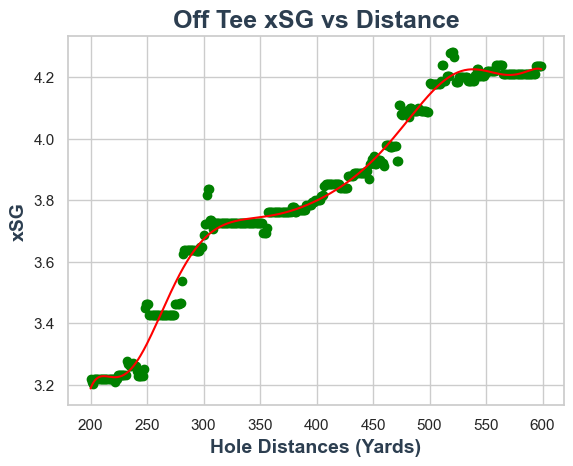

In [28]:
plt.scatter(list_of_distances, Tee_Predictions, color='green', label='Scatter Plot')

coefficients = np.polyfit(list_of_distances, Tee_Predictions, 10)
poly_line = np.poly1d(coefficients)
plt.plot(list_of_distances, poly_line(list_of_distances), color='red', label='Best Fit Line')

plt.xlabel('Hole Distances (Yards)', fontsize=14, fontweight='bold', color='#2c3e50')  # Dark blue for the label
plt.ylabel('xSG', fontsize=14, fontweight='bold', color='#2c3e50')
plt.title('Off Tee xSG vs Distance', fontsize=18, fontweight='bold', color='#2c3e50')  # Larger title with dark blue color

# Fairway xSG vs Rough xSG

In [29]:
#fairway
Fairway_Predictions = []
list_of_distances = [round(x, 1) for x in range(5, 300)]
f = X_valid.iloc[31]
input = f.to_frame().T

for i in list_of_distances:
    input['distance_to_pin'] = i
    preds = stack_model.predict(input)
    Fairway_Predictions.append(preds[0])

#rough
Rough_Predictions = []
list_of_distances = [round(x, 1) for x in range(5, 300)]
f = X_valid.iloc[115]
input = f.to_frame().T

for i in list_of_distances:
    input['distance_to_pin'] = i
    preds = stack_model.predict(input)
    Rough_Predictions.append(preds[0])

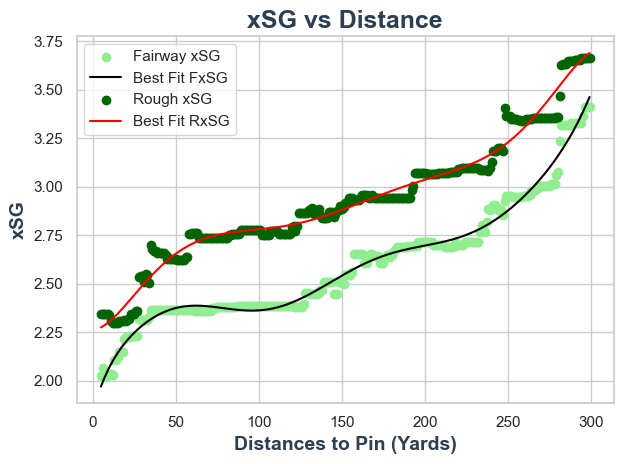

In [30]:
# Scatter plot for Fairway Predictions
plt.scatter(list_of_distances, Fairway_Predictions, color='lightgreen', label='Fairway xSG')
coefficients = np.polyfit(list_of_distances, Fairway_Predictions, 10)
poly_line = np.poly1d(coefficients)
plt.plot(list_of_distances, poly_line(list_of_distances), color='black', label='Best Fit FxSG')

# Scatter plot for Rough Predictions
plt.scatter(list_of_distances, Rough_Predictions, color='darkgreen', label='Rough xSG')
coefficients = np.polyfit(list_of_distances, Rough_Predictions, 7)
poly_line = np.poly1d(coefficients)
plt.plot(list_of_distances, poly_line(list_of_distances), color='red', label='Best Fit RxSG')


plt.xlabel('Distances to Pin (Yards)', fontsize=14, fontweight='bold', color='#2c3e50')  # Dark blue for the label
plt.ylabel('xSG', fontsize=14, fontweight='bold', color='#2c3e50')
plt.title('xSG vs Distance', fontsize=18, fontweight='bold', color='#2c3e50')  # Larger title with dark blue colo

# Show legend
plt.legend()
plt.tight_layout()


# Show the plot
plt.show()

# Putting

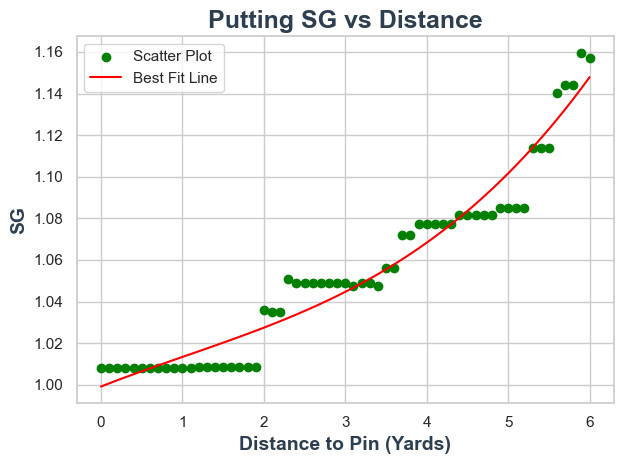

In [31]:
# I should train putts totally seperate lol

#Lies = ['Rough','Green','Fairway','Bunker','Tee']
Putting_Predictions = []
list_of_distances = [round(x * 0.1, 1) for x in range(0, 61)]
f = X_valid.iloc[17]
input = f.to_frame().T
#input['lie_location'] = 'Green'

for i in list_of_distances:
    input['distance_to_pin'] = i
    preds = stack_model.predict(input)
    Putting_Predictions.append(preds[0])

plt.scatter(list_of_distances, Putting_Predictions, color='green', label='Scatter Plot')

coefficients = np.polyfit(list_of_distances, Putting_Predictions, 3)
poly_line = np.poly1d(coefficients)
plt.plot(list_of_distances, poly_line(list_of_distances), color='red', label='Best Fit Line')

# Add labels and title with improved style
plt.xlabel('Distance to Pin (Yards)', fontsize=14, fontweight='bold', color='#2c3e50')  # Dark blue for the label
plt.ylabel('SG', fontsize=14, fontweight='bold', color='#2c3e50')
plt.title('Putting SG vs Distance', fontsize=18, fontweight='bold', color='#2c3e50')  # Larger title with dark blue color


# Show legend
plt.legend()

# Show the plot with tight layout
plt.tight_layout()

# Show the plot
plt.show()

# **Final xSG vs True Score**

-TODO! make plottable